In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
from spire.operators.tomography import AstraToolbox
#from spire.operators.image import *
from spire.utils import *
ph = np.load("data/Brain256.npz")["data"]

In [3]:
tomo = AstraToolbox(ph.shape[0], 40)
si = tomo.proj(ph)

In [4]:
from pypwt import Wavelets
W = Wavelets(ph, "haar", 8, do_cycle_spinning=True*0)
from spire.algorithms.fista import fista_wavelets
P0 = lambda x : tomo.proj(x)
P0T = lambda x : tomo.backproj(x)
# scaled
P = lambda x : tomo.proj(x)/tomo.n_a*pi/2
PT = lambda x : tomo.fbp(x)

In [5]:
# Set to True to use iterative FBP instead of backproj (faster convergence)
USE_FBP = False



if USE_FBP:
    P0 = P
    P0T = PT
    si = si/tomo.n_a*pi/2
else:
    print("Not using FBP")

Not using FBP


In [6]:
if USE_FBP: en_w, r_w = fista_wavelets(si, W, P, PT, 1., n_it=201, dta=True) 
else: en_w, r_w = fista_wavelets(si, W, P0, P0T, 1., n_it=1501, dta=True) 


Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.175646e+04
[0] : energy 6.426540e+10 	 fidelity 6.426536e+10 	 L1 4.936299e+04
[10] : energy 3.733616e+09 	 fidelity 3.733373e+09 	 L1 2.425310e+05
[20] : energy 9.893149e+08 	 fidelity 9.889136e+08 	 L1 4.013122e+05
[30] : energy 2.863127e+08 	 fidelity 2.857868e+08 	 L1 5.259228e+05
[40] : energy 7.253244e+07 	 fidelity 7.192240e+07 	 L1 6.100377e+05
[50] : energy 1.597911e+07 	 fidelity 1.532100e+07 	 L1 6.581125e+05
[60] : energy 3.787285e+06 	 fidelity 3.106365e+06 	 L1 6.809201e+05
[70] : energy 1.592761e+06 	 fidelity 9.032735e+05 	 L1 6.894871e+05
[80] : energy 1.171972e+06 	 fidelity 4.802849e+05 	 L1 6.916874e+05
[90] : energy 1.025947e+06 	 fidelity 3.342409e+05 	 L1 6.917064e+05
[100] : energy 9.431425e+05 	 fidelity 2.519057e+05 	 L1 6.912368e+05
[110] : energy 8.889837e+05 	 fidelity 1.982193e+05 	 L1 6.907644e+05
[120] : energy 8.508909e+05 	 fidelity 1.605486e+05 	 L1 6.903424e+05
[130] : ene

<IPython.core.display.Javascript object>


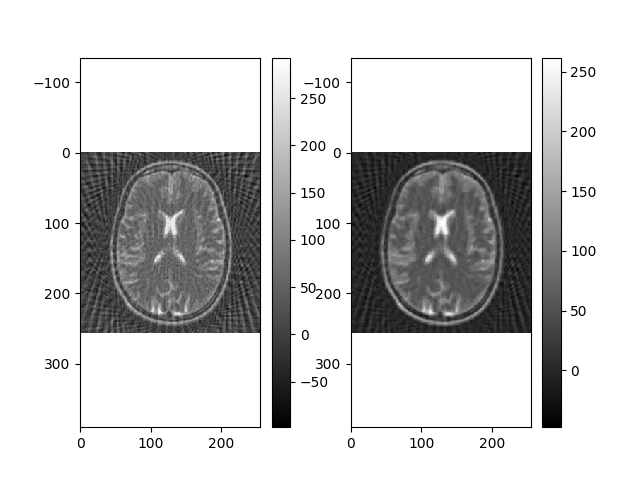

In [7]:
ims([tomo.fbp(si/tomo.n_a*pi/2), r_w], cmap="gray")

In [8]:
from spire.operators.misc import *
from spire.operators.image import *
def fista_wavelets2(data, W, K, Kadj, Lambda, Lip=None, n_it=100, return_all=True, normalize=False, dta=False):
    dta = 1 if bool(dta) else 0
    normalize = 1 if bool(normalize) else 0
    if Lip is None:
        print("Warn: Lipschitz constant not provided, computing it with 20 iterations")
        Lip = power_method(K, Kadj, data, 20)**2 * 1.2
        print("Lip = %e" % Lip)

    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(Kadj(data))
    y = np.zeros_like(x)
    t = 1.
    for k in range(0, n_it):
        grad_y = Kadj(K(y) - data)
        x_old = x
        W.set_image((y - (1.0/Lip)*grad_y).astype(np.float32))
        W.forward()
        W.soft_threshold(Lambda/Lip, do_threshold_appcoeffs=dta, normalize=normalize)
        W.inverse()
        x = W.image
        t_old = t
        t = 0.5*(1 + sqrt(1+4*t*t))
        y = x + ((t_old - 1)/t) * (x - x_old) 
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(K(x)-data)
            l1 = W.norm1()
            energy = fidelity + Lambda*l1
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t L1 %e" % (k, energy, fidelity, l1))
    if return_all: return en, x
    else: return x

    
    
    
    

In [9]:
if USE_FBP: en_w2, r_w2 = fista_wavelets2(si, W, P, PT, 1., n_it=201, dta=True)
else:  en_w2, r_w2 = fista_wavelets2(si, W, P0, P0T, 1., n_it=1501, dta=True)


Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.175646e+04
[0] : energy 6.426540e+10 	 fidelity 6.426536e+10 	 L1 4.936299e+04
[10] : energy 1.726708e+09 	 fidelity 1.726371e+09 	 L1 3.367621e+05
[20] : energy 1.729931e+08 	 fidelity 1.724082e+08 	 L1 5.848672e+05
[30] : energy 2.851301e+07 	 fidelity 2.780250e+07 	 L1 7.105062e+05
[40] : energy 1.841588e+07 	 fidelity 1.768872e+07 	 L1 7.271528e+05
[50] : energy 6.949222e+06 	 fidelity 6.247420e+06 	 L1 7.018013e+05
[60] : energy 3.638000e+06 	 fidelity 2.952446e+06 	 L1 6.855536e+05
[70] : energy 2.589061e+06 	 fidelity 1.903871e+06 	 L1 6.851899e+05
[80] : energy 1.735723e+06 	 fidelity 1.046526e+06 	 L1 6.891972e+05
[90] : energy 1.326190e+06 	 fidelity 6.356767e+05 	 L1 6.905135e+05
[100] : energy 1.115475e+06 	 fidelity 4.261264e+05 	 L1 6.893486e+05
[110] : energy 9.786559e+05 	 fidelity 2.908618e+05 	 L1 6.877941e+05
[120] : energy 8.975722e+05 	 fidelity 2.111464e+05 	 L1 6.864258e+05
[130] : ene

In [10]:
"""
figure();
plot(en_w);
plot(en_w2);
"""

'\nfigure();\nplot(en_w);\nplot(en_w2);\n'

In [11]:
def plotlog(D, absmin=True, legend=None):
    plt.figure()
    lim = np.inf
    for d in D:
        if absmin: lim = min(lim, d.min())
        else: lim = d.min()
        plt.plot(np.log10((d-lim)/(d[0]-lim)))

    if legend: plt.legend(legend)
    plt.show()
    

In [12]:

def fista_wavelets3(data, W, K, Kadj, Lambdas, restart_every, Lip=None, n_it=100, return_all=True, normalize=False, dta=False):
    dta = 1 if bool(dta) else 0
    normalize = 1 if bool(normalize) else 0
    if Lip is None:
        print("Warn: Lipschitz constant not provided, computing it with 20 iterations")
        Lip = power_method(K, Kadj, data, 20)**2 * 1.2
        print("Lip = %e" % Lip)

    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(Kadj(data))
    y = np.zeros_like(x)
    t = 1.
    Lambda = Lambdas[0]
    nLambda = 0
    for k in range(0, n_it):
        grad_y = Kadj(K(y) - data)
        x_old = x
        W.set_image((y - (1.0/Lip)*grad_y).astype(np.float32))
        W.forward()
        W.soft_threshold(Lambda/Lip, do_threshold_appcoeffs=dta, normalize=normalize)
        W.inverse()
        x = W.image
        t_old = t
        t = 0.5*(1 + sqrt(1+4*t*t))
        if k > 0 and nLambda < len(Lambdas)-1 and (k % restart_every) == 0: 
            # t = 1. # warm start ?
            nLambda = nLambda +1
            Lambda = Lambdas[nLambda]
            print("Lambda = %e" % Lambda)
        y = x + ((t_old - 1)/t) * (x - x_old) # TODO : see what would be the best parameter "a"
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(K(x)-data)
            l1 = W.norm1()
            energy = fidelity + Lambda*l1
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t L1 %e" % (k, energy, fidelity, l1))
    if return_all: return en, x
    else: return x


In [13]:
if USE_FBP: en_w3, r_w3 = fista_wavelets3(si, W, P, PT, [20, 10., 5., 1.], restart_every=50, n_it=201, dta=True)
else: en_w3, r_w3 = fista_wavelets3(si, W, P0, P0T, [20, 10., 5., 1.], restart_every=50, n_it=1501, dta=True)


Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.175646e+04
[0] : energy 6.426683e+10 	 fidelity 6.426584e+10 	 L1 4.925807e+04
[10] : energy 1.735068e+09 	 fidelity 1.728372e+09 	 L1 3.347871e+05
[20] : energy 1.851410e+08 	 fidelity 1.735551e+08 	 L1 5.792918e+05
[30] : energy 4.133510e+07 	 fidelity 2.732915e+07 	 L1 7.002971e+05
[40] : energy 3.120383e+07 	 fidelity 1.697244e+07 	 L1 7.115695e+05
Lambda = 1.000000e+01
[50] : energy 1.282731e+07 	 fidelity 6.029302e+06 	 L1 6.798012e+05
[60] : energy 9.577861e+06 	 fidelity 2.994892e+06 	 L1 6.582969e+05
[70] : energy 8.459628e+06 	 fidelity 1.923736e+06 	 L1 6.535892e+05
[80] : energy 7.561825e+06 	 fidelity 1.034774e+06 	 L1 6.527051e+05
[90] : energy 7.101844e+06 	 fidelity 6.138035e+05 	 L1 6.488040e+05
Lambda = 5.000000e+00
[100] : energy 3.624891e+06 	 fidelity 4.121115e+05 	 L1 6.425559e+05
[110] : energy 3.468350e+06 	 fidelity 2.815600e+05 	 L1 6.373580e+05
[120] : energy 3.367784e+06 	 fidelit

<IPython.core.display.Javascript object>


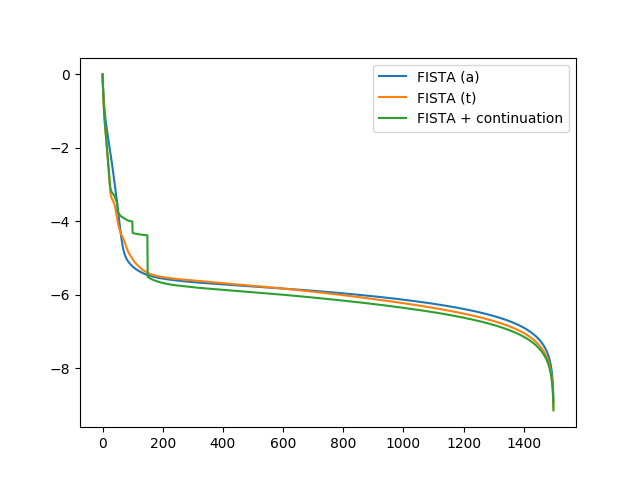

'\nfigure()\nplot(en_w)\nplot(en_w2)\nplot(en_w3)\nlegend(["FISTA (a)", "FISTA (t)", "FISTA + continuation"])\n'

In [14]:
plotlog([en_w, en_w2, en_w3], legend=["FISTA (a)", "FISTA (t)", "FISTA + continuation"])
#plotlog([en_w, en_w2, en_w3o, en_w3], legend=["FISTA (a)", "FISTA (t)", "FISTA + continuation (cold)", "FISTA + continuation"])


'''
figure()
plot(en_w)
plot(en_w2)
plot(en_w3)
legend(["FISTA (a)", "FISTA (t)", "FISTA + continuation"])
'''

<IPython.core.display.Javascript object>


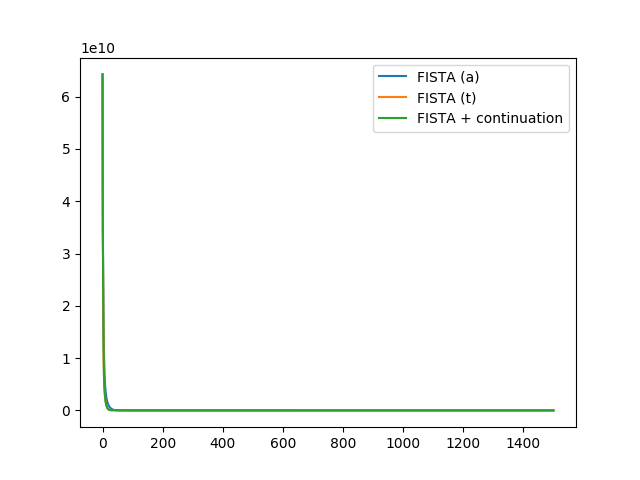

In [15]:
figure()
plot(en_w)
plot(en_w2)
#plot(en_w3o)
plot(en_w3)
legend(["FISTA (a)", "FISTA (t)", "FISTA + continuation"])
#legend(["FISTA (a)", "FISTA (t)", "FISTA + continuation (cold)" ,"FISTA + continuation"])

Conclusion
-------------

Looks like we can get a factor of two in the number of iterations when using "regular" proj/backproj.

Authors use the notion of "warm restarting", but it is not clear if the step size should be reinitialized as well. 
Experiments show that:
  - FISTA-t is faster than FISTA-a, except when choosing $a$ close to $2$
  - In terms of convergence to "the" solution, it is better *not* to restart the step.
  - However, cold restarting in the final step makes the energy decrease slow, i.e the approximate solution is almost immediately reached
  
**For iterative FBP**, the conclusion change:
   - Using the continuation method does not seem to be beneficial
   - FISTA-a seems more stable than FISTA-t for $a > 2$, for example $a = 10$

Deconvolution
===============

In [16]:
from scipy.misc import ascent
img = ascent().astype("f")
# bin to 256x256 for faster tests
img = img.reshape((256, 2, 256, 2)).mean(axis=1).mean(axis=-1)

In [17]:
# Create another problem: deconvolution
from spire.operators.convolution import ConvolutionOperator
sigma = 1.1
g1 = gaussian1D(sigma)
C = ConvolutionOperator(g1)
B = lambda x : C * x
BT = lambda x : C.adjoint() * x

In [18]:
check_adjoint(B, BT, img.shape, img.shape)

3.637978807091713e-12

In [19]:

img_b = B(img)

In [30]:
enb_w, rb_w = fista_wavelets(img_b, W, B, BT, 1.e-2, n_it=501, dta=True)
enb_w2, rb_w2 = fista_wavelets2(img_b, W, B, BT, 1.e-2, n_it=501, dta=True)
enb_w3, rb_w3 = fista_wavelets3(img_b, W, B, BT, [5e-1, 1e-1, 2e-2, 1e-2], restart_every=200, n_it=501, dta=True)


Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.199094e+00
[0] : energy 1.117553e+07 	 fidelity 1.117116e+07 	 L1 4.367754e+05
[10] : energy 3.198609e+04 	 fidelity 2.384781e+04 	 L1 8.138282e+05
[20] : energy 1.404297e+04 	 fidelity 5.646581e+03 	 L1 8.396388e+05
[30] : energy 1.079766e+04 	 fidelity 2.339501e+03 	 L1 8.458160e+05
[40] : energy 9.658576e+03 	 fidelity 1.209577e+03 	 L1 8.448999e+05
[50] : energy 9.130050e+03 	 fidelity 7.284774e+02 	 L1 8.401573e+05
[60] : energy 8.827115e+03 	 fidelity 4.900327e+02 	 L1 8.337082e+05
[70] : energy 8.630401e+03 	 fidelity 3.646292e+02 	 L1 8.265772e+05
[80] : energy 8.492587e+03 	 fidelity 2.985087e+02 	 L1 8.194078e+05
[90] : energy 8.389152e+03 	 fidelity 2.636914e+02 	 L1 8.125461e+05
[100] : energy 8.307070e+03 	 fidelity 2.465394e+02 	 L1 8.060531e+05
[110] : energy 8.240780e+03 	 fidelity 2.392834e+02 	 L1 8.001496e+05
[120] : energy 8.185901e+03 	 fidelity 2.372238e+02 	 L1 7.948678e+05
[130] : ene

<IPython.core.display.Javascript object>


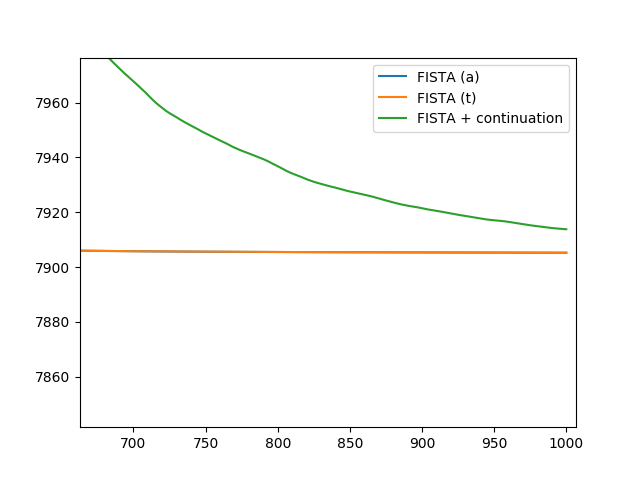

<IPython.core.display.Javascript object>


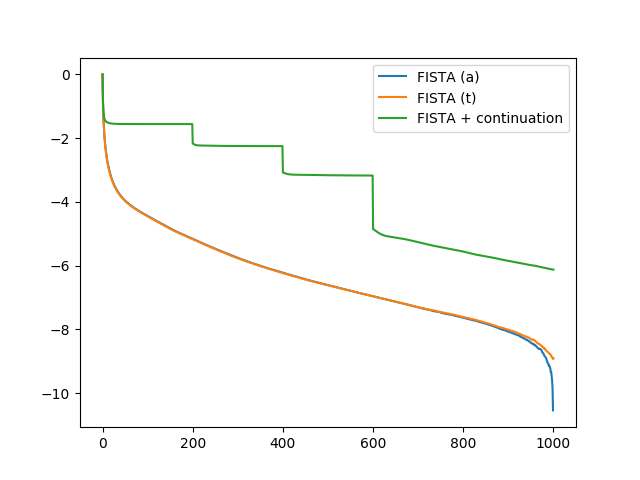

In [31]:
figure()
plot(enb_w)
plot(enb_w2)
#plot(en_w3o)
plot(enb_w3)
legend(["FISTA (a)", "FISTA (t)", "FISTA + continuation"])


plotlog([enb_w, enb_w2, enb_w3], legend=["FISTA (a)", "FISTA (t)", "FISTA + continuation"])


<IPython.core.display.Javascript object>


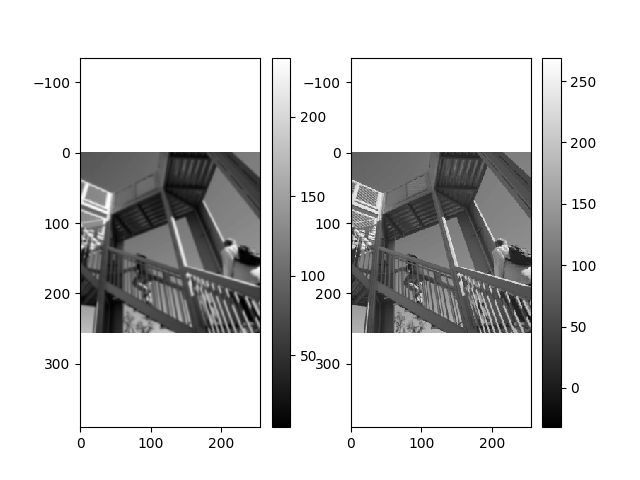

In [22]:
ims([img_b, rb_w], cmap="gray")

Conclusion (deblur with wavelets analysis)
-------------------------------------------------

  - The continuation method does not seem to benefit to the convergence speed. 
  - FISTA-t is faster than FISTA-a.
  - Important to choose a warm restart over a cold restart (i.e not resetting $t = 1$) !

In [23]:
# TEST
def fista_wavelets(data, W, K, Kadj, Lambda, Lip=None, n_it=100, return_all=True, normalize=False, dta=False):
    dta = 1 if bool(dta) else 0
    normalize = 1 if bool(normalize) else 0
    if Lip is None:
        print("Warn: Lipschitz constant not provided, computing it with 20 iterations")
        Lip = power_method(K, Kadj, data, 20)**2 * 1.2
        print("Lip = %e" % Lip)

    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(Kadj(data))
    y = np.zeros_like(x)
    for k in range(0, n_it):
        grad_y = Kadj(K(y) - data)
        x_old = x
        W.set_image((y - (1.0/Lip)*grad_y).astype(np.float32))
        W.forward()
        W.soft_threshold(Lambda/Lip, do_threshold_appcoeffs=dta, normalize=normalize)
        W.inverse()
        x = W.image
        y = x + ((1.*k)/(k+1+2.1))*(x - x_old) # TODO : see what would be the best parameter "a"
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(K(x)-data)
            l1 = W.norm1()
            energy = fidelity + Lambda*l1
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t L1 %e" % (k, energy, fidelity, l1))
    if return_all: return en, x
    else: return x

    
    

Optimized Gradient method
============================

In [24]:
# Optimized Gradient method

def fessler_ogm(data, W, K, Kadj, Lambda, Lip=None, n_it=100, return_all=True, normalize=False, dta=False):
    dta = 1 if bool(dta) else 0
    normalize = 1 if bool(normalize) else 0
    if Lip is None:
        print("Warn: Lipschitz constant not provided, computing it with 20 iterations")
        Lip = power_method(K, Kadj, data, 20)**2 * 1.2
        print("Lip = %e" % Lip)

    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(Kadj(data))
    y = np.zeros_like(x)
    t = 1.
    for k in range(0, n_it):
        grad_y = Kadj(K(y) - data)
        x_old = np.copy(x)
        W.set_image((y - (1.0/Lip)*grad_y).astype(np.float32))
        W.forward()
        W.soft_threshold(Lambda/Lip, do_threshold_appcoeffs=dta, normalize=normalize)
        W.inverse()
        x = W.image
        
        t_old = t
        t = 0.5*(1 + sqrt(1+4*t*t))
        y = x + ((t_old - 1)/t) * (x - x_old)  + t_old/t * (x - y)
        
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(K(x)-data)
            l1 = W.norm1()
            energy = fidelity + Lambda*l1
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t L1 %e" % (k, energy, fidelity, l1))
    if return_all: return en, x
    else: return x
    
    
    
    

In [29]:
enb_w4, rb_w4 = fessler_ogm(img_b, W, B, BT, 1e-2, n_it=501, dta=True)



Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.199094e+00
[0] : energy 1.117553e+07 	 fidelity 1.117116e+07 	 L1 4.367754e+05
[10] : energy 1.907119e+04 	 fidelity 1.071433e+04 	 L1 8.356858e+05
[20] : energy 1.096109e+04 	 fidelity 2.472812e+03 	 L1 8.488272e+05
[30] : energy 9.443781e+03 	 fidelity 9.852621e+02 	 L1 8.458519e+05
[40] : energy 8.891906e+03 	 fidelity 5.229972e+02 	 L1 8.368909e+05
[50] : energy 8.605845e+03 	 fidelity 3.430316e+02 	 L1 8.262814e+05
[60] : energy 8.430391e+03 	 fidelity 2.714722e+02 	 L1 8.158919e+05
[70] : energy 8.308353e+03 	 fidelity 2.452361e+02 	 L1 8.063117e+05
[80] : energy 8.217623e+03 	 fidelity 2.380329e+02 	 L1 7.979590e+05
[90] : energy 8.147739e+03 	 fidelity 2.378449e+02 	 L1 7.909894e+05
[100] : energy 8.093266e+03 	 fidelity 2.398614e+02 	 L1 7.853405e+05
[110] : energy 8.053507e+03 	 fidelity 2.424998e+02 	 L1 7.811007e+05
[120] : energy 8.025694e+03 	 fidelity 2.439987e+02 	 L1 7.781696e+05
[130] : ene

<IPython.core.display.Javascript object>


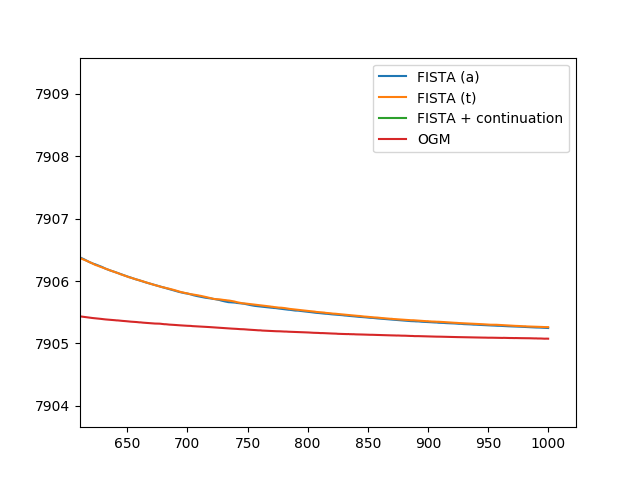

<IPython.core.display.Javascript object>


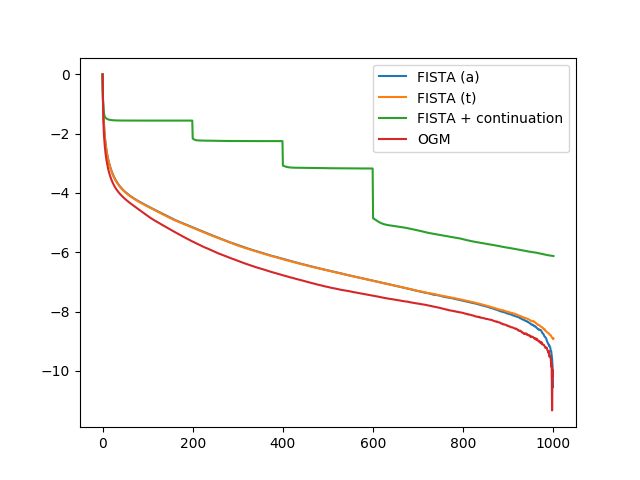

In [32]:
figure()
plot(enb_w)
plot(enb_w2)
plot(enb_w3)
plot(enb_w4)
legend(["FISTA (a)", "FISTA (t)","FISTA + continuation", "OGM"])


plotlog([enb_w, enb_w2, enb_w3, enb_w4], legend=["FISTA (a)", "FISTA (t)", "FISTA + continuation", "OGM"])


In [27]:
if USE_FBP: en_w4, r_w4 = fessler_ogm(si, W, P, PT, 1., n_it=201, dta=True)
else: en_w4, r_w4 = fessler_ogm(si, W, P0, P0T, 1., n_it=1501, dta=True)


Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.175646e+04
[0] : energy 6.426540e+10 	 fidelity 6.426536e+10 	 L1 4.936299e+04
[10] : energy 6.489721e+08 	 fidelity 6.485048e+08 	 L1 4.672497e+05
[20] : energy 3.977499e+07 	 fidelity 3.906545e+07 	 L1 7.095374e+05
[30] : energy 1.756882e+07 	 fidelity 1.684687e+07 	 L1 7.219488e+05
[40] : energy 5.519724e+06 	 fidelity 4.833483e+06 	 L1 6.862409e+05
[50] : energy 3.159221e+06 	 fidelity 2.473540e+06 	 L1 6.856812e+05
[60] : energy 1.818302e+06 	 fidelity 1.127314e+06 	 L1 6.909882e+05
[70] : energy 1.346241e+06 	 fidelity 6.567870e+05 	 L1 6.894543e+05
[80] : energy 1.086695e+06 	 fidelity 3.994341e+05 	 L1 6.872604e+05
[90] : energy 9.314867e+05 	 fidelity 2.460575e+05 	 L1 6.854292e+05
[100] : energy 8.525231e+05 	 fidelity 1.686289e+05 	 L1 6.838942e+05
[110] : energy 7.950852e+05 	 fidelity 1.127767e+05 	 L1 6.823086e+05
[120] : energy 7.620278e+05 	 fidelity 8.162505e+04 	 L1 6.804028e+05
[130] : ene

<IPython.core.display.Javascript object>


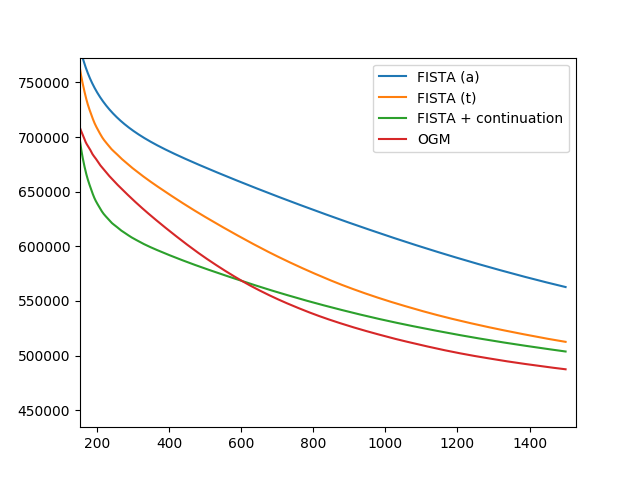

<IPython.core.display.Javascript object>


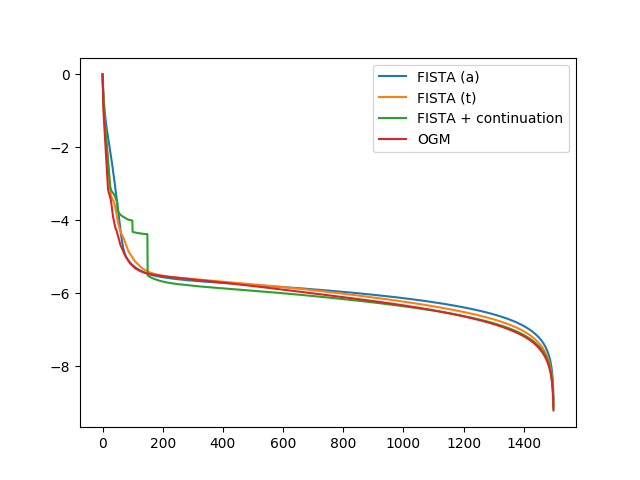

In [28]:
figure()
plot(en_w)
plot(en_w2)
plot(en_w3)
plot(en_w4)
legend(["FISTA (a)", "FISTA (t)","FISTA + continuation", "OGM"])


plotlog([en_w, en_w2, en_w3, en_w4], legend=["FISTA (a)", "FISTA (t)", "FISTA + continuation", "OGM"])


Conclusion on optimized gradient method
-------------------------------------------

This method seems to be the best method among all, even for FBP/plain BP.